# Convolutional Layers

### Implementing convolutional layers with keras

In [2]:

import sys

assert sys.version_info >= (3, 7)

In [3]:
import tensorflow as tf
from sklearn.datasets import load_sample_images
import matplotlib.pyplot as plt

In [4]:
if tf.config.list_physical_devices('GPU'):
  print("Connected to GPU successfully!")
else:
  print("No GPU connnected")

Connected to GPU successfully!


In [5]:
images=load_sample_images()["images"]
images=tf.keras.layers.CenterCrop(height=75,width=115)(images)
images=tf.keras.layers.Rescaling(scale=1/255)(images)

In [6]:
images.shape

TensorShape([2, 75, 115, 3])

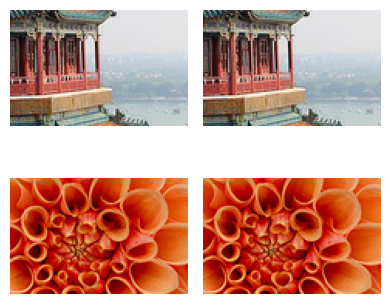

In [7]:
plt.figure(figsize=(4,4))
for img_idx in (0,1):
    for j in (0,1):
        plt.subplot(2,2,img_idx*2+j+1)
        plt.imshow(images[img_idx,:,:,:])
        plt.axis("off")
plt.tight_layout()
plt.show()

In [8]:
tf.keras.utils.set_random_seed(42)

conv_layer=tf.keras.layers.Conv2D(filters=32,kernel_size=8)
fmap=conv_layer(images)

In [9]:
fmap.shape

TensorShape([2, 68, 108, 32])

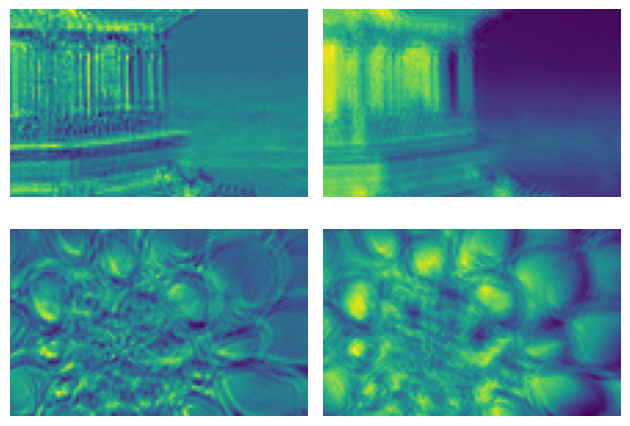

In [10]:
for img_idx in (0,1):
    for fmap_idx in (0,1):
        plt.subplot(2,2,img_idx*2+fmap_idx+1)
        plt.imshow(fmap[img_idx,:,:,fmap_idx])
        plt.axis("off")
plt.tight_layout()
plt.show()

In [11]:
conv_layer=tf.keras.layers.Conv2D(filters=32,kernel_size=7,padding="same")
fmap=conv_layer(images)

In [12]:
fmap.shape

TensorShape([2, 75, 115, 32])

In [13]:
conv_layer=tf.keras.layers.Conv2D(filters=32,kernel_size=7,padding="same",
                                 strides=2)
fmap=conv_layer(images)
fmap.shape

TensorShape([2, 38, 58, 32])

In [14]:
kernel,biases=conv_layer.get_weights()

In [15]:
kernel.shape

(7, 7, 3, 32)

In [16]:
biases.shape

(32,)

In [17]:
filters=tf.random.normal([7,7,3,2])
biases=tf.zeros([2])
fmaps=tf.nn.conv2d(images,filters,strides=1,padding="SAME")+biases

In [18]:
fmaps.shape

TensorShape([2, 75, 115, 2])

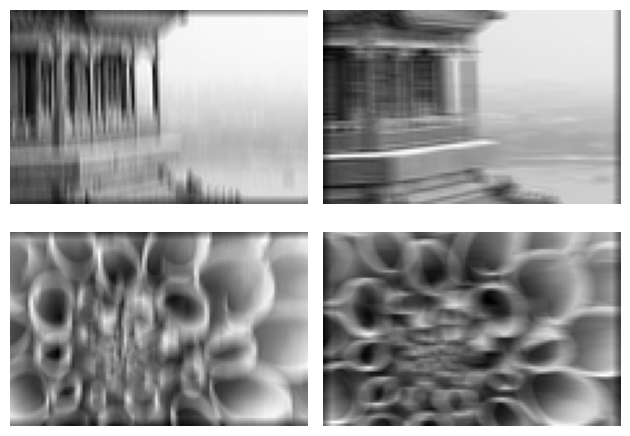

In [19]:
import numpy as np

filters=np.zeros([7,7,3,2])
filters[:,3,:,0] = 1
filters[3,:,:,1] = 1
fmaps=tf.nn.conv2d(images,filters,strides=1,padding="SAME")+biases

for image_idx in (0,1):
  for fmap_idx in (0,1):
    plt.subplot(2,2,image_idx*2+fmap_idx+1)
    plt.imshow(fmaps[image_idx,:,:,fmap_idx],cmap="gray")
    plt.axis("off")
plt.tight_layout()


# Pooling Layers


### Max pooling


In [20]:
max_pool=tf.keras.layers.MaxPool2D(pool_size=2)

In [21]:
output=max_pool(images)

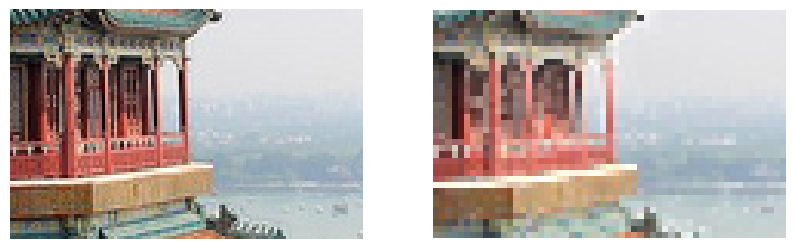

In [22]:
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(images[0])
plt.axis("off")
plt.subplot(1,2,2)
plt.imshow(output[0])
plt.axis("off")
plt.show()


##### Depth-wise pooling

In [23]:
class DepthPool(tf.keras.layers.Layer):
  def __init__(self,pool_size=2,**kwargs):
    super().__init__(**kwargs)
    self.pool_size=pool_size

  def call(self,inputs):
    shape=tf.shape(inputs)
    groups=shape[-1]//self.pool_size
    new_shape=tf.concat([shape[:-1],[groups,self.pool_size]],axis=0)
    return tf.reduce_max(tf.reshape(inputs,new_shape),axis=-1)    #So for every [batch, height, width, group], it
                                                                    #looks at the 3 values in that group and picks the maximum.




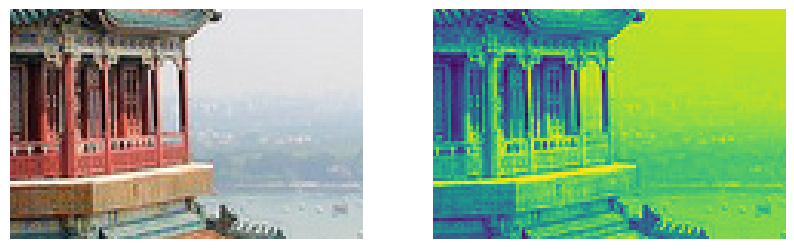

In [24]:
depth_output=DepthPool(pool_size=3)(images)

plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(images[0])
plt.axis("off")
plt.subplot(1,2,2)
plt.imshow(depth_output[0])
plt.axis("off")
plt.show()

##### Global Average Pooling

In [25]:
global_avg_pooling=tf.keras.layers.GlobalAveragePooling2D()

In [26]:
global_avg_pooling=tf.keras.layers.Lambda(lambda X:tf.reduce_mean(X,axis=[1,2]))

# CNN Architectures

###### Tackling Fashion MNIST With a CNN

In [27]:
mnist=tf.keras.datasets.fashion_mnist.load_data()
(X_train_full,y_train_full),(X_test,y_test)=mnist
X_train_full=np.expand_dims(X_train_full,axis=-1).astype(np.float32)/255
X_test=np.expand_dims(X_test,axis=-1).astype(np.float32)/255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [28]:
from functools import partial

DefaultConv2D=partial(tf.keras.layers.Conv2D,kernel_size=3,padding="same",activation="relu",
                      kernel_initializer="he_normal")

model=tf.keras.Sequential([
    tf.keras.layers.InputLayer(shape=[28,28,1]),
    DefaultConv2D(filters=64,kernel_size=7),
    tf.keras.layers.MaxPool2D(),
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    tf.keras.layers.MaxPool2D(),
    DefaultConv2D(filters=256),
    DefaultConv2D(filters=256),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128,activation="relu",kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64,activation="relu",kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(10,activation="softmax")


])

In [29]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 64)     │         3,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 14, 14, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 14, 14, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 7, 7, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 7, 7, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 3, 3, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,413,834 (5.39 MB)

 Trainable params: 1,413,834 (5.39 MB)

 Non-trainable params: 0 (0.00 B)

In [32]:
model.compile(loss="sparse_categorical_crossentropy",optimizer="adam",
              metrics=["accuracy"])
model.fit(X_train,y_train,
          epochs=10,
          validation_data=(X_valid,y_valid))
score=model.evaluate(X_test,y_test)
X_new=X_test[:10]
model.predict(X_new)

Epoch 1/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 25s 11ms/step - accuracy: 0.5776 - loss: 1.1775 - val_accuracy: 0.8622 - val_loss: 0.3925
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 31s 7ms/step - accuracy: 0.8374 - loss: 0.4822 - val_accuracy: 0.8812 - val_loss: 0.3426
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 21s 7ms/step - accuracy: 0.8670 - loss: 0.3898 - val_accuracy: 0.8994 - val_loss: 0.2732
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.8858 - loss: 0.3351 - val_accuracy: 0.8966 - val_loss: 0.2970
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.8961 - loss: 0.3051 - val_accuracy: 0.8906 - val_loss: 0.3022
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.9045 - loss: 0.2839 - val_accuracy: 0.8990 - val_loss: 0.2921
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.9119 - loss: 0.2625 - val_accuracy: 0.9070 - val_loss: 0.2653
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.9164 - loss: 

array([[4.2299914e-37, 1.8945555e-42, 1.4694560e-36, 9.1364660e-42,
        2.5689579e-38, 9.3169287e-14, 1.7623101e-34, 3.6711392e-09,
        3.3463688e-27, 1.0000000e+00],
       [7.4189275e-12, 6.8694753e-28, 9.9999321e-01, 2.0387955e-19,
        9.5448396e-09, 1.1851291e-27, 6.7829119e-06, 1.5999613e-37,
        1.9082316e-21, 2.8101106e-36],
       [0.0000000e+00, 1.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 1.0000000e+00, 0.0000000e+00, 5.6051939e-45,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [1.6754373e-03, 1.2191969e-11, 7.2927505e-04, 3.8513854e-06,
        2.0223339e-03, 9.4767783e-10, 9.9556917e-01, 4.5951079e-10,
        5.0842409e-08, 1.4081333e-09],
       [0.0000000e+00, 1.0000000e+00, 0.0000000e+00, 3.2201839e-42,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.00

## GoogLeNet

In [30]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Input, Concatenate
from tensorflow.keras.models import Model

def InceptionModule(x,f1,f3r,f3,f5r,f5,proj):

  path1=Conv2D(f1,kernel_size=1,padding="same",activation="relu")(x)

  path2=Conv2D(f3r,kernel_size=1,padding="same",activation="relu")(x)
  path2=Conv2D(f3,kernel_size=3,padding="same",activation="relu")(path2)

  path3=Conv2D(f5r,kernel_size=1,padding="same",activation="relu")(x)
  path3=Conv2D(f5,kernel_size=5,padding="same",activation="relu")(path3)

  path4=MaxPooling2D(pool_size=3,strides=1,padding="same")(x)
  path4=Conv2D(proj,kernel_size=1,padding="same",activation="relu")(path4)

  return Concatenate(axis=-1)([path1,path2,path3,path4])

In [31]:
from tensorflow.keras.layers import BatchNormalization,Dense,GlobalAveragePooling2D,Activation,Input,Dropout

input_layer=Input(shape=(28,28,1))

x=Conv2D(filters=64,kernel_size=7,strides=2,padding="same",activation="relu")(input_layer)
x=MaxPooling2D(pool_size=3,strides=2,padding="same")(x)
x=BatchNormalization()(x)

x=Conv2D(64,kernel_size=1,padding="same",activation="relu")(x)
x=Conv2D(192,kernel_size=3,padding="same",activation="relu")(x)
x=BatchNormalization()(x)
x=Activation("relu")(x)
x=MaxPooling2D(pool_size=3,strides=2,padding="same")(x)

x=InceptionModule(x,64,96,128,12,32,32)
x=InceptionModule(x,128,128,192,32,96,64)
x=MaxPooling2D(pool_size=3,strides=2,padding="same")(x)

x=InceptionModule(x,192, 96, 208, 16, 48, 64)
x=InceptionModule(x,160, 112, 224, 24, 64, 64)
x=InceptionModule(x, 128, 128, 256, 24, 64, 64)
x=InceptionModule(x,112, 144, 288, 32, 64, 64)
x=InceptionModule(x,256, 160, 320, 32, 128, 128)
x=MaxPooling2D(pool_size=3,strides=2,padding="same")(x)

x=InceptionModule(x,256, 160, 320, 32, 128, 128)
x=InceptionModule(x,384, 192, 384, 48, 128, 128)
x=GlobalAveragePooling2D()(x)
x=Dropout(0.2)(x)
x=Dense(10,activation="softmax")(x)


model=Model(input_layer,x)
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 14, 14,    │      3,200 │ input_layer_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 7, 7, 64)  │          0 │ conv2d_8[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 7, 7, 64)  │        256 │ max_pooling2d_4[… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 7, 7, 64)  │      4,160 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 7, 7, 192) │    110,784 │ conv2d_9[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 7, 7, 192) │        768 │ conv2d_10[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 7, 7, 192) │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 4, 4, 192) │          0 │ activation[0][0]  │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 4, 4, 96)  │     18,528 │ max_pooling2d_5[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_14 (Conv2D)  │ (None, 4, 4, 12)  │      2,316 │ max_pooling2d_5[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 4, 4, 192) │          0 │ max_pooling2d_5[… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 4, 4, 64)  │     12,352 │ max_pooling2d_5[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 4, 4, 128) │    110,720 │ conv2d_12[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 4, 4, 32)  │      9,632 │ conv2d_14[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_16 (Conv2D)  │ (None, 4, 4, 32)  │      6,176 │ max_pooling2d_6[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 4, 4, 256) │          0 │ conv2d_11[0][0],  │
│ (Concatenate)       │                   │            │ conv2d_13[0][0],  │
│                     │                   │            │ conv2d_15[0][0],  │
│                     │                   │            │ conv2d_16[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_18 (Conv2D)  │ (None, 4, 4, 128) │     32,896 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 4, 4, 32)  │      8,224 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 5,974,582 (22.79 MB)

 Trainable params: 5,974,070 (22.79 MB)

 Non-trainable params: 512 (2.00 KB)

In [32]:
model.compile(loss="sparse_categorical_crossentropy",optimizer="adam",
              metrics=["accuracy"])
model.fit(X_train,y_train,
          epochs=10,
          validation_data=(X_valid,y_valid))
score=model.evaluate(X_test,y_test)
X_new=X_test[:10]
model.predict(X_new)

Epoch 1/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 84s 29ms/step - accuracy: 0.6571 - loss: 0.8695 - val_accuracy: 0.8338 - val_loss: 0.4773
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 35s 13ms/step - accuracy: 0.8518 - loss: 0.4236 - val_accuracy: 0.8596 - val_loss: 0.3870
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 41s 12ms/step - accuracy: 0.8747 - loss: 0.3653 - val_accuracy: 0.8696 - val_loss: 0.3809
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - accuracy: 0.8829 - loss: 0.3388 - val_accuracy: 0.8762 - val_loss: 0.3352
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - accuracy: 0.8867 - loss: 0.3279 - val_accuracy: 0.8832 - val_loss: 0.3419
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 41s 13ms/step - accuracy: 0.8920 - loss: 0.3070 - val_accuracy: 0.8992 - val_loss: 0.2883
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - accuracy: 0.9029 - loss: 0.2795 - val_accuracy: 0.8912 - val_loss: 0.3294
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - accuracy: 0.9064 -

array([[3.12479009e-15, 1.10698153e-13, 1.17341405e-14, 4.69779855e-14,
        3.00193383e-13, 2.79139291e-04, 8.28148136e-16, 3.41407547e-04,
        9.29832947e-11, 9.99379396e-01],
       [1.40680757e-04, 3.08248804e-12, 9.98630702e-01, 1.51349211e-09,
        1.72109649e-05, 7.61711004e-18, 1.21131237e-03, 2.07986373e-16,
        3.83258529e-11, 4.18537773e-17],
       [0.00000000e+00, 1.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 1.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00],
       [1.02443239e-02, 3.84803105e-04, 1.23013100e-02, 8.60187877e-03,
        7.43398517e-02, 3.06527509e-04, 8.92953396e-01, 3.33454841e-06,
        8.63876659e-04, 7.81275105e-07],
       [0.00000000e+00, 1.00000000e+00, 0.00000000e+00, 0.00000000e+00,
   

## ResNet-34

In [1]:
DefaultConv2D=partial(tf.keras.layers.Conv2D,kernel_size=3,strides=1,padding="same",
                      kernel_initializer="he_normal",use_bias=False)

class ResidualUnit(tf.keras.layers.Layer):
  def __init__(self,filters,strides=1,activation="relu",**kwargs):
     super().__init__(**kwargs)
     self.activation=tf.keras.activations.get(activation)
     self.main_layers=[
         DefaultConv2D(filters,strides=strides),
         tf.keras.layers.BatchNormalization(),
         self.activation,
         DefaultConv2D(filters),
         tf.keras.layers.BatchNormalization()
     ]
     self.skip_layers=[]
     if strides>1:
      self.skip_layers=[
          DefaultConv2D(filters,kernel_size=1,strides=strides),
          tf.keras.layers.BatchNormalization()
      ]

  def call(self,inputs):
    Z=inputs
    for layer in self.main_layers:
      Z=layer(Z)
    skip_Z=inputs
    for layer in self.skip_layers:
      skip_Z=layer(skip_Z)

    return self.activation(Z+skip_Z)

NameError: name 'partial' is not defined

In [58]:
mean=np.mean(X_train_full,axis=(0,1,2))
std=np.std(X_train_full,axis=(0,1,2))

data_preprocessing=tf.keras.Sequential([
    tf.keras.layers.Normalization(mean=mean.tolist(),variance=(std**2).tolist()),
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomContrast(0.1)
])

In [53]:
model=tf.keras.Sequential([
    tf.keras.layers.InputLayer(shape=[32,32,3]),
    data_preprocessing,
    DefaultConv2D(64,kernel_size=3,strides=1,padding="same"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    # tf.keras.layers.MaxPooling2D(pool_size=3,strides=2),
])

prev_filter=64
for filters in [64]*3 +[128]*4 + [256]*6 + [512]*3:
  strides = 1 if filters==prev_filter else 2
  model.add(ResidualUnit(filters=filters,strides=strides))
  prev_filter=filters

model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(tf.keras.layers.Dense(100,activation="softmax"))



In [54]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_593 (Conv2D)             │ (None, 32, 32, 64)     │         1,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_90          │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_11 (Activation)      │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_32 (ResidualUnit) │ (None, 32, 32, 64)     │        74,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_33 (ResidualUnit) │ (None, 32, 32, 64)     │        74,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_34 (ResidualUnit) │ (None, 32, 32, 64)     │        74,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_35 (ResidualUnit) │ (None, 16, 16, 128)    │       230,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_36 (ResidualUnit) │ (None, 16, 16, 128)    │       295,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_37 (ResidualUnit) │ (None, 16, 16, 128)    │       295,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_38 (ResidualUnit) │ (None, 16, 16, 128)    │       295,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_39 (ResidualUnit) │ (None, 8, 8, 256)      │       920,576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_40 (ResidualUnit) │ (None, 8, 8, 256)      │     1,181,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_41 (ResidualUnit) │ (None, 8, 8, 256)      │     1,181,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_42 (ResidualUnit) │ (None, 8, 8, 256)      │     1,181,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_43 (ResidualUnit) │ (None, 8, 8, 256)      │     1,181,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_44 (ResidualUnit) │ (None, 8, 8, 256)      │     1,181,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_45 (ResidualUnit) │ (None, 4, 4, 512)      │     3,676,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_46 (ResidualUnit) │ (None, 4, 4, 512)      │     4,722,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_47 (ResidualUnit) │ (None, 4, 4, 512)      │     4,722,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_11     │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 100)            │        51,300 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,345,316 (81.43 MB)

 Trainable params: 21,328,292 (81.36 MB)

 Non-trainable params: 17,024 (66.50 KB)

In [55]:
(X_train_full, y_train_full), (X_test, y_test) = tf.keras.datasets.cifar100.load_data()
X_train_full = X_train_full.astype("float32") / 255.0
X_test = X_test.astype("float32") / 255.0
X_train,y_train=X_train_full[5000:],y_train_full[5000:]
X_valid,y_valid=X_train_full[:5000],y_train_full[:5000]

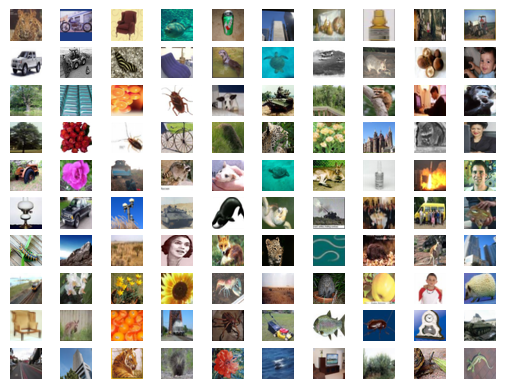

In [50]:
import matplotlib.pyplot as plt
for i in range(100):
  plt.subplot(10,10,i+1)
  plt.imshow(X_train[i])
  plt.axis('off')
plt.show()


In [56]:
model.compile(loss="sparse_categorical_crossentropy",optimizer="adam",metrics=["accuracy"])

In [57]:
history=model.fit(X_train,y_train,
                  epochs=10,
                  validation_data=(X_valid,y_valid))

Epoch 1/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 166s 97ms/step - accuracy: 0.0714 - loss: 4.2687 - val_accuracy: 0.1600 - val_loss: 3.7463
Epoch 2/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 175s 87ms/step - accuracy: 0.2180 - loss: 3.1731 - val_accuracy: 0.2616 - val_loss: 3.6155
Epoch 3/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 122s 87ms/step - accuracy: 0.3552 - loss: 2.4617 - val_accuracy: 0.3744 - val_loss: 2.7793
Epoch 4/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 125s 89ms/step - accuracy: 0.4711 - loss: 1.9382 - val_accuracy: 0.3696 - val_loss: 2.8272
Epoch 5/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 140s 87ms/step - accuracy: 0.5847 - loss: 1.4687 - val_accuracy: 0.3612 - val_loss: 3.1056
Epoch 6/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 141s 87ms/step - accuracy: 0.7110 - loss: 0.9882 - val_accuracy: 0.3802 - val_loss: 3.2705
Epoch 7/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 142s 87ms/step - accuracy: 0.8054 - loss: 0.6164 - val_accuracy: 0.4432 - val_loss: 2.9426
Epoch 8/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 142s 87ms/step - accuracy: 